In [3]:
import numpy as np
import math
import pandas as pd
import numpy.random as npr
from matplotlib import pyplot as plt

In [5]:
S0 = 100
r = 0.05
sigma = 0.25
T = 1.0
I = 50000
M = 50

In [4]:
def gen_sn(M, I, anti_paths=True, mo_match=True):
    if anti_paths is True:
        sn = npr.standard_normal((M+1, int(I/2)))
        sn = np.concatenate((sn, -sn), axis=1)
    else:
        sn = npr.standard_normal((M+1, I))
    if mo_match is True:
        sn = (sn - sn.mean()) / sn.std()
    return sn

In [12]:
def gbm_mcs_dyna(K, option='call'):
    dt = T/ M
    S = np.zeros((M+1, I))
    S[0] = S0
    sn = gen_sn(M, I)
    for t in range(1, M+1):
        S[t] = S[t-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * math.sqrt(dt) * sn[t])
    if option == 'call':
        hT = np.maximum(S[-1] - K, 0)
    elif option == 'put':
        hT = np.maximum(K-S[-1], 0)
    else:
        raise ValueError("Must enter call or put as option type")
        
    C0 = math.exp(-r * T) * np.mean(hT)
    return C0

In [8]:
gbm_mcs_dyna(K=110., option='call')

8.024727933590523

In [9]:
gbm_mcs_dyna(K= 110., option='put')

12.605309142719266

In [13]:
gbm_mcs_dyna(K= 110., option='fake_value')

ValueError: Must enter call or put as option type

In [21]:
def gbm_mcs_american(K, option='call'):
    # Implements Least Squares Monte Carlo algorithm for American call and put options
    dt = T/ M
    df = math.exp(-r * dt)
    S = np.zeros((M+1, I))
    S[0] = 50
    sn = gen_sn(M,I)
    for t in range(1, M+1):
        S[t] = S[t-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * math.sqrt(dt) * sn[t])
    if option == 'call':
        h = np.maximum(S-K, 0)
    elif option == 'put':
        h = np.maximum(K-S, 0)
    else:
        raise ValueError("Must be put or call")
    V = np.copy(h)
    for t in range(M-1, 0, -1):
        reg = np.polyfit(S[t], V[t+1] * df, 7)
        C = np.polyval(reg, S[t])
        V[t] = np.where(C > h[t], V[t+1] * df, h[t])
    
    C0 = df * np.mean(V[1])
    return C0

In [22]:
gbm_mcs_american(110.)q

0.006676067550359049

In [24]:
def black_scholes_call_value(S0, K, T, r, sigma):
    from math import log, sqrt, exp
    from scipy import stats
    # European call option in Black Scholes model
    S0 = float(S0)
    d1 = (log(S0/K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = (log(S0/K) + (r - 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    value = (S0 * stats.norm.cdf(d1, 0.0, 1.0) - K * exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0))
    return value

In [26]:
def calculate_vega(S0, K, T, r, sigma):
    from math import log, sqrt
    from scipy import stats 
    S0 = float(S0)
    d1 = (log(S0/K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    vega = S0 * stats.norm.pdf(d1, 0.0, 1.0) * sqrt(T)
    return vega

In [27]:
def black_scholes_implied_volatility(S0, K, T, r, C0, sigma_est, it=100):
    for i in range(it):
        sigma_est -= ((black_scholes_call_value(S0, K, T, r, sigma_est) - C0) / calculate_vega(S0, K, T ,r ,sigma_est))
    return sigma_est

In [29]:
black_scholes_implied_volatility(50, 110, 10, 0.5, 150, 300)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


nan

In [31]:
# Normal log returns: Log returns log(St/Ss) = log St - log Ss between two times are normally distributed 
# at any time t > 0, the values of St are log nomrally distributed
import math
import numpy as np
import scipy.stats as scs
import statsmodels.api as sm

In [32]:
def gen_paths(S0, r, sigma, T, M, I):
    # Generate Monte carlo paths for geometric Brownian motion
    dt = T/ M
    paths = np.zeros((M+1, I))
    paths[0] = S0
    for t in range(1, M+1):
        rand = np.random.standard_normal(I)
        rand = (rand - rand.mean()) / rand.std()
        paths[t] = paths[t-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * math.sqrt(dt) * rand)
    return paths

In [33]:
S0 = 100
r = 0.05
sigma = 0.2
T = 1.0
M = 50
I = 250000
np.random.seed(1000)
paths = gen_paths(S0, r, sigma, T, M, I)

In [36]:
S0 * math.exp(r*T)
# Expected value

105.12710963760242

In [35]:
paths[-1].mean() 
# Average simulate value

105.12645392478755

In [37]:
paths[:,0].round(4)

array([100.    ,  97.821 ,  98.5573, 106.1546, 105.899 ,  99.8363,
       100.0145, 102.6589, 105.6643, 107.1107, 108.7943, 108.2449,
       106.4105, 101.0575, 102.0197, 102.6052, 109.6419, 109.5725,
       112.9766, 113.0225, 112.5476, 114.5585, 109.942 , 112.6271,
       112.7502, 116.3453, 115.0443, 113.9586, 115.8831, 117.3705,
       117.9185, 110.5539, 109.9687, 104.9957, 108.0679, 105.7822,
       105.1585, 104.3304, 108.4387, 105.5963, 108.866 , 108.3284,
       107.0077, 106.0034, 104.3964, 101.0637,  98.3776,  97.135 ,
        95.4254,  96.4271,  96.3386])

In [38]:
log_returns = np.log(paths[1:]/ paths[:-1])

In [39]:
log_returns[:,0].round(4)

array([-0.022 ,  0.0075,  0.0743, -0.0024, -0.059 ,  0.0018,  0.0261,
        0.0289,  0.0136,  0.0156, -0.0051, -0.0171, -0.0516,  0.0095,
        0.0057,  0.0663, -0.0006,  0.0306,  0.0004, -0.0042,  0.0177,
       -0.0411,  0.0241,  0.0011,  0.0314, -0.0112, -0.0095,  0.0167,
        0.0128,  0.0047, -0.0645, -0.0053, -0.0463,  0.0288, -0.0214,
       -0.0059, -0.0079,  0.0386, -0.0266,  0.0305, -0.0049, -0.0123,
       -0.0094, -0.0153, -0.0324, -0.0269, -0.0127, -0.0178,  0.0104,
       -0.0009])

In [40]:
import pandas as pd

In [41]:
raw = pd.read_csv('data/tr_eikon_eod_data.csv', index_col = 0, parse_dates=True).dropna()

In [42]:
raw.head()

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-04,30.572827,30.950,20.88,133.90,173.08,113.33,1132.99,20.04,1.4411,1120.00,47.71,109.80
2010-01-05,30.625684,30.960,20.87,134.69,176.14,113.63,1136.52,19.35,1.4368,1118.65,48.17,109.70
2010-01-06,30.138541,30.770,20.80,132.25,174.26,113.71,1137.14,19.16,1.4412,1138.50,49.34,111.51
2010-01-07,30.082827,30.452,20.60,130.00,177.67,114.19,1141.69,19.06,1.4318,1131.90,49.10,110.82
2010-01-08,30.282827,30.660,20.83,133.52,174.31,114.57,1144.98,18.13,1.4412,1136.10,49.84,111.37


In [47]:
data = raw[symbols]

In [46]:
symbols = ['SPY', 'GLD', 'AAPL.O', 'MSFT.O']

In [48]:
data = data.dropna()

In [49]:
data.head()

,SPY,GLD,AAPL.O,MSFT.O
Date,,,,
2010-01-04,113.33,109.80,30.572827,30.950
2010-01-05,113.63,109.70,30.625684,30.960
2010-01-06,113.71,111.51,30.138541,30.770
2010-01-07,114.19,110.82,30.082827,30.452
2010-01-08,114.57,111.37,30.282827,30.660


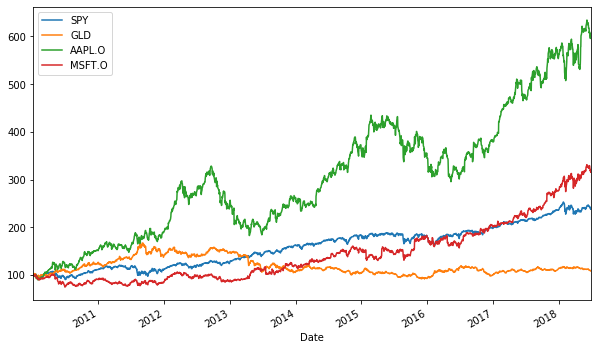

In [50]:
(data/ data.iloc[0] * 100).plot(figsize=(10,6))

In [51]:
log_returns = np.log(data / data.shift(1))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000014D88C5EEF0>,
      dtype=object)

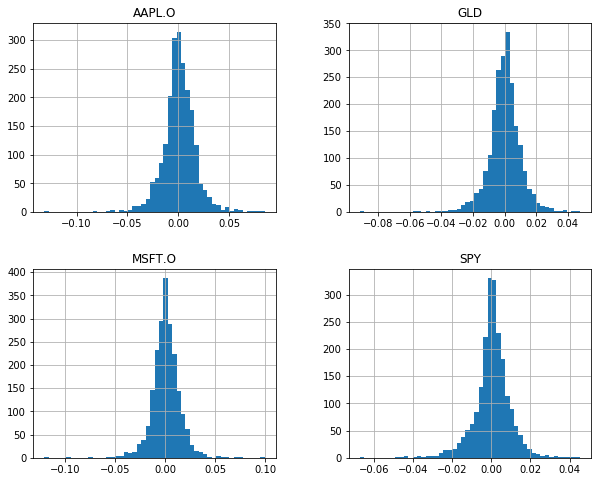

In [52]:
log_returns.hist(bins=50, figsize=(10,8))

In [53]:
noa = len(symbols)

In [54]:
data = raw[symbols]

In [55]:
rets = np.log(data / data.shift(1))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000014D8906C780>,
      dtype=object)

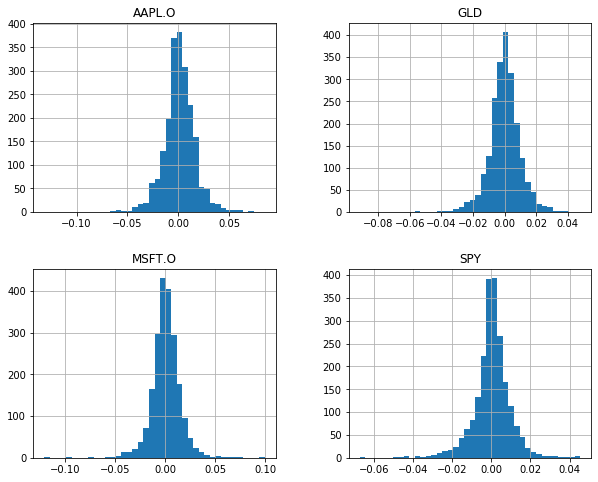

In [56]:
rets.hist(bins=40, figsize=(10,8))

In [57]:
rets.mean() * 252

SPY       0.102928
GLD       0.009141
AAPL.O    0.212359
MSFT.O    0.136648
dtype: float64

In [58]:
rets.cov() * 252

,SPY,GLD,AAPL.O,MSFT.O
SPY,0.021939,0.000062,0.021039,0.022244
GLD,0.000062,0.026209,0.001513,-0.000347
AAPL.O,0.021039,0.001513,0.063773,0.023427
MSFT.O,0.022244,-0.000347,0.023427,0.050917


In [59]:
# General formula for expected portfolio return
def ev_portfolio_return(rets, weights):
    return np.sum(rets.mean() * weights) * 252

In [60]:
weights = np.random.random(noa)

In [61]:
weights /= np.sum(weights)

In [62]:
weights.sum()

1.0

In [63]:
ev_portfolio_return(rets, weights)

0.17436363391255663